In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38381/status,
Dashboard: /proxy/38381/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35903,Workers: 4
Dashboard: /proxy/38381/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:41947,Total threads: 4
Dashboard: /proxy/42507/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:46567,


In [2]:
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu']
hu = hu.sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90,-50.1,.1))), 1, np.nan)
land_ice_mask = land_ice_mask.interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, 
                                     land_ice_mask['lon'] + 360, 
                                     land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon':'_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj':sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj':'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_lin = xr.open_dataset('../data/smooth_div_line.nc')
div_lin = div_lin['__xarray_dataarray_variable__']

In [3]:
u = xr.open_dataset('../data/uas-monthly-1979_2015-erai.nc')['uas'].mean('time')
v = xr.open_dataset('../data/vas-monthly-1979_2015-erai.nc')['vas'].mean('time')
p = xr.open_dataset('../data/psl-monthly-1979_2015-erai.nc')['psl'].mean('time')

In [4]:
uw, lon = add_cyclic_point(u, coord = u['lon'].values)
vw, lon = add_cyclic_point(v, coord = v['lon'].values)
pw, lon = add_cyclic_point(p, coord = p['lon'].values)

In [5]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [6]:
from palettable.colorbrewer.diverging import RdYlBu_11_r

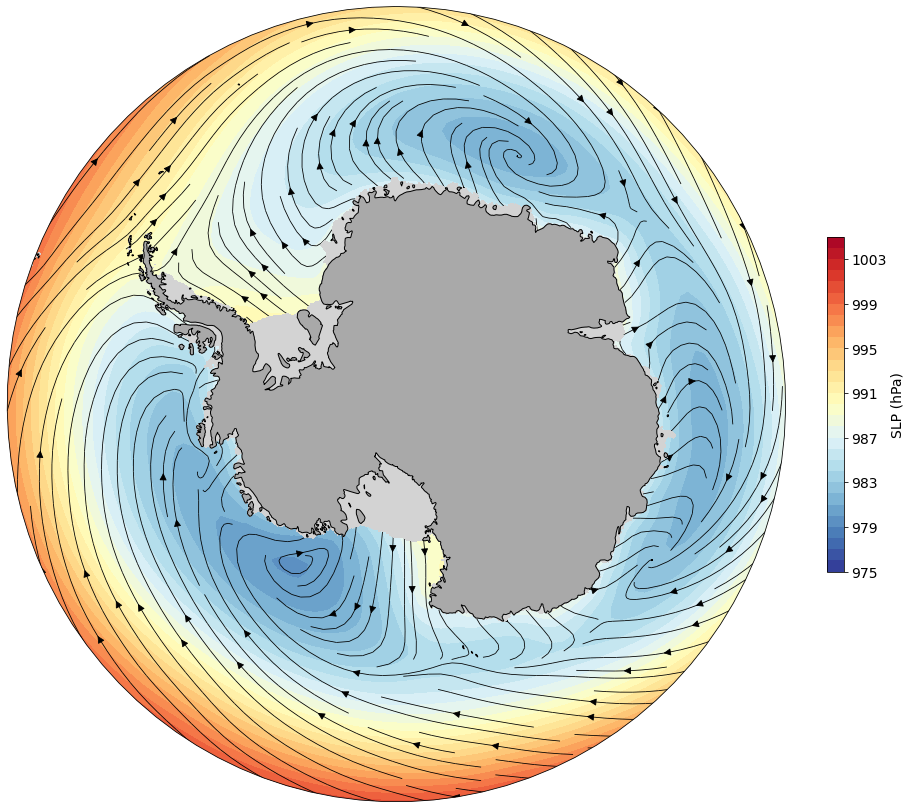

In [78]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15, 15))
axs = fig.add_subplot(projection = ccrs.SouthPolarStereo())
axs.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
axs.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'lightgrey', linewidths = 0.5, transform = ccrs.PlateCarree())
axs.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'k', facecolor = 'darkgrey'))
# Fix ugly line
axs.plot([180, 180], [-90, -84.5], zorder = 3, color = 'darkgrey', linewidth = 2, transform = ccrs.PlateCarree())
axs.set_boundary(circle, transform = axs.transAxes)

cf = axs.contourf(lon, p['lat'], pw/100, levels = np.arange(975, 1006, 1), cmap = RdYlBu_11_r.mpl_colormap, zorder = 0, transform = ccrs.PlateCarree())
plt.colorbar(cf, fraction = .02).set_label('SLP (hPa)')
axs.streamplot(lon, u['lat'], uw, vw, color = 'k', linewidth = .8, density = 2, arrowsize = 1.5, transform = ccrs.PlateCarree(), zorder = 0)
plt.savefig('antmargins1.jpg', bbox_inches = 'tight')

In [79]:
div_lin = xr.open_dataset('../data/smooth_div_line.nc')
div_lin = div_lin['__xarray_dataarray_variable__']

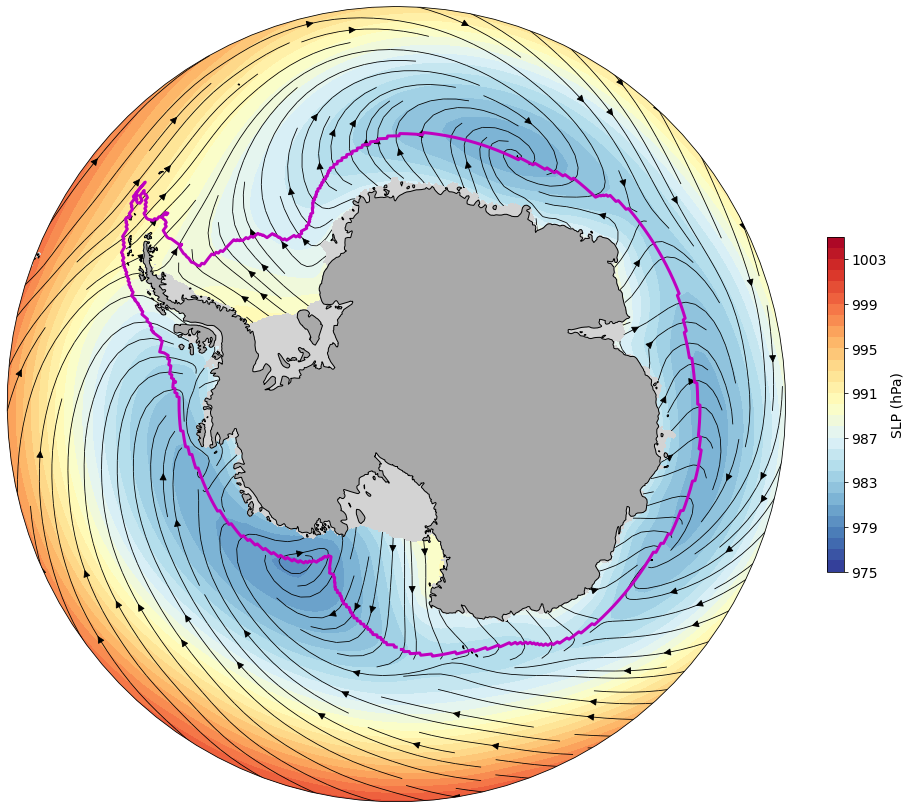

In [80]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15, 15))
axs = fig.add_subplot(projection = ccrs.SouthPolarStereo())
axs.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
axs.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'lightgrey', linewidths = 0.5, transform = ccrs.PlateCarree())
axs.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'k', facecolor = 'darkgrey'))
# Fix ugly line
axs.plot([180, 180], [-90, -84.5], zorder = 3, color = 'darkgrey', linewidth = 2, transform = ccrs.PlateCarree())
axs.set_boundary(circle, transform = axs.transAxes)

cf = axs.contourf(lon, p['lat'], pw/100, levels = np.arange(975, 1006, 1), cmap = RdYlBu_11_r.mpl_colormap, zorder = 0, transform = ccrs.PlateCarree())
plt.colorbar(cf, fraction = .02).set_label('SLP (hPa)')
axs.streamplot(lon, u['lat'], uw, vw, color = 'k', linewidth = .8, density = 2, arrowsize = 1.5, transform = ccrs.PlateCarree(), zorder = 0)
axs.plot(div_lin[0], div_lin[1], 'm', linewidth = 3, zorder = 2, transform = ccrs.PlateCarree())
plt.savefig('antmargins2.jpg', bbox_inches = 'tight')

In [12]:
u = xr.open_dataset('../data/uas-monthly-1979_2015-cmip6.nc')['uas'].sel(time = slice('2005-01-01', '2015-01-01')).mean('time')
v = xr.open_dataset('../data/vas-monthly-1979_2015-cmip6.nc')['vas'].sel(time = slice('2005-01-01', '2015-01-01')).mean('time')
p = xr.open_dataset('../data/psl-monthly-1979_2015-cmip6.nc')['psl'].sel(time = slice('2005-01-01', '2015-01-01')).mean('time')

In [13]:
uw, lon = add_cyclic_point(u, coord = u['lon'].values)
vw, lon = add_cyclic_point(v, coord = v['lon'].values)
pw, lon = add_cyclic_point(p, coord = p['lon'].values)

In [14]:
up = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp85.nc')['uas'].sel(time = slice('2090-01-01', '2100-01-01')).mean('time')
vp = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp85.nc')['vas'].sel(time = slice('2090-01-01', '2100-01-01')).mean('time')
pp = xr.open_dataset('../data/psl-monthly-2015_2100-cmip6ssp85.nc')['psl'].sel(time = slice('2090-01-01', '2100-01-01')).mean('time')

In [15]:
upw, lon = add_cyclic_point(up, coord = u['lon'].values)
vpw, lon = add_cyclic_point(vp, coord = v['lon'].values)
ppw, lon = add_cyclic_point(pp, coord = p['lon'].values)

In [24]:
div_line_hist = xr.open_dataarray('div_line_2005-2015-cmip6.nc')
div_line_proj = xr.open_dataarray('div_line_2015-2100-cmip6.nc')

In [25]:
div_line_hist

<xarray.DataArray 'lat' (lon: 480)>
array([-67.5 , -68.25, -68.25, ..., -67.5 , -67.5 , -67.5 ])
Coordinates:
  * lon      (lon) float64 -180.0 -179.2 -178.5 -177.8 ... 177.8 178.5 179.2
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

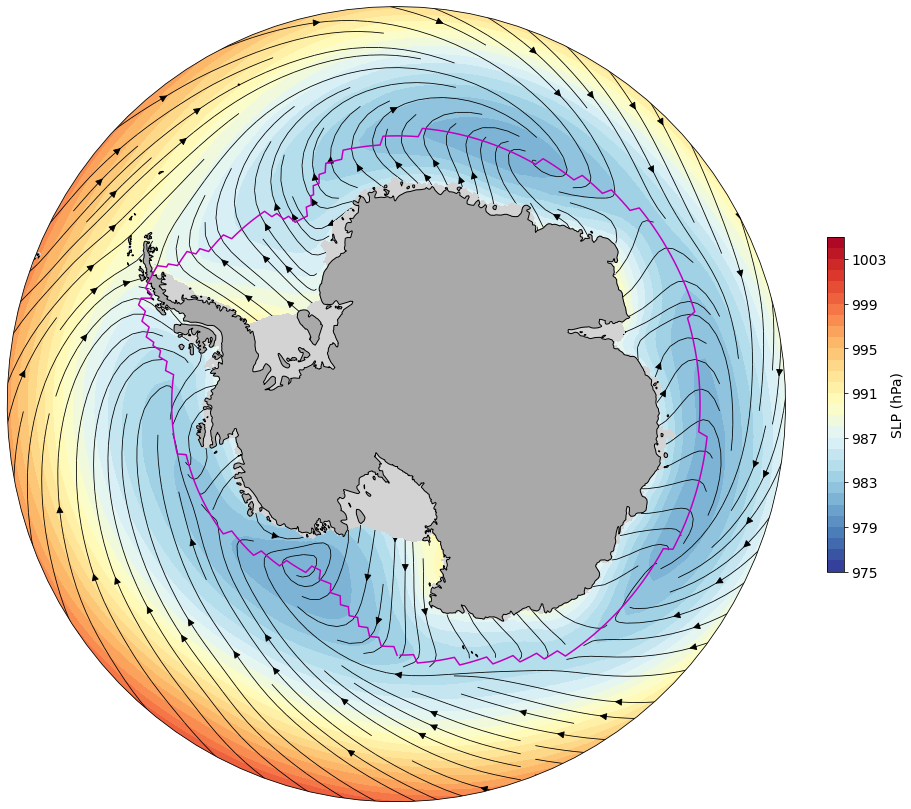

In [27]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15, 15))
axs = fig.add_subplot(projection = ccrs.SouthPolarStereo())
axs.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
axs.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'lightgrey', linewidths = 0.5, transform = ccrs.PlateCarree())
axs.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'k', facecolor = 'darkgrey'))
# Fix ugly line
axs.plot([180, 180], [-90, -84.5], zorder = 3, color = 'darkgrey', linewidth = 2, transform = ccrs.PlateCarree())
axs.set_boundary(circle, transform = axs.transAxes)

cf = axs.contourf(lon, p['lat'], pw/100, levels = np.arange(975, 1006, 1), cmap = RdYlBu_11_r.mpl_colormap, zorder = 0, transform = ccrs.PlateCarree())
plt.colorbar(cf, fraction = .02).set_label('SLP (hPa)')
axs.plot(div_line_hist['lon'], div_line_hist, color = 'm', transform = ccrs.PlateCarree())
axs.streamplot(lon, u['lat'], uw, vw, color = 'k', linewidth = .8, density = 2, arrowsize = 1.5, transform = ccrs.PlateCarree(), zorder = 0)
plt.savefig('antmargins11.jpg', bbox_inches = 'tight')

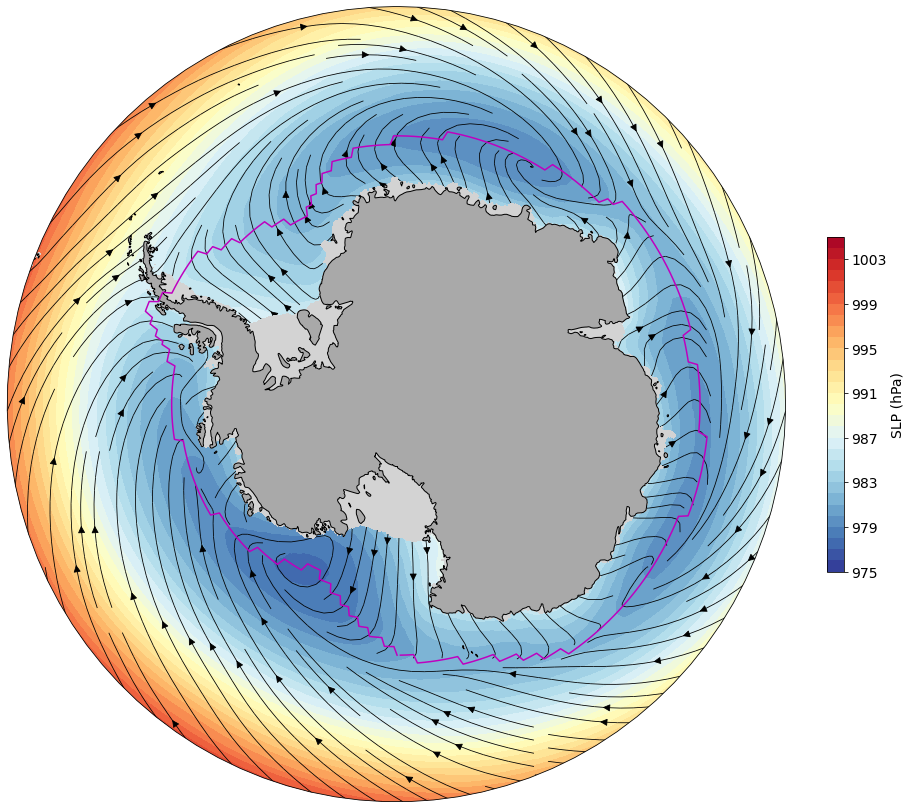

In [28]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15, 15))
axs = fig.add_subplot(projection = ccrs.SouthPolarStereo())
axs.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
axs.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'lightgrey', linewidths = 0.5, transform = ccrs.PlateCarree())
axs.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'k', facecolor = 'darkgrey'))
# Fix ugly line
axs.plot([180, 180], [-90, -84.5], zorder = 3, color = 'darkgrey', linewidth = 2, transform = ccrs.PlateCarree())
axs.set_boundary(circle, transform = axs.transAxes)

cf = axs.contourf(lon, pp['lat'], ppw/100, levels = np.arange(975, 1006, 1), cmap = RdYlBu_11_r.mpl_colormap, zorder = 0, transform = ccrs.PlateCarree())
plt.colorbar(cf, fraction = .02).set_label('SLP (hPa)')
axs.plot(div_line_proj['lon'], div_line_proj, color = 'm', transform = ccrs.PlateCarree())
axs.streamplot(lon, up['lat'], upw, vpw, color = 'k', linewidth = .8, density = 2, arrowsize = 1.5, transform = ccrs.PlateCarree(), zorder = 0)
plt.savefig('antmargins12.jpg', bbox_inches = 'tight')

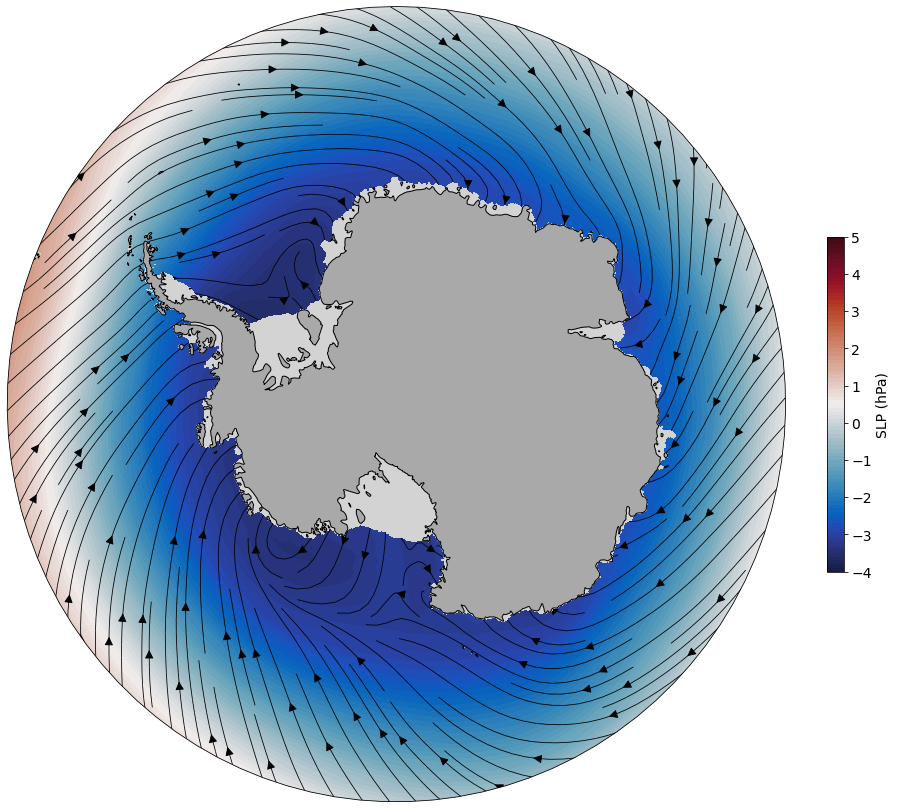

In [22]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15, 15))
axs = fig.add_subplot(projection = ccrs.SouthPolarStereo())
axs.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
axs.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'lightgrey', linewidths = 0.5, transform = ccrs.PlateCarree())
axs.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'k', facecolor = 'darkgrey'))
# Fix ugly line
axs.plot([180, 180], [-90, -84.5], zorder = 3, color = 'darkgrey', linewidth = 2, transform = ccrs.PlateCarree())
axs.set_boundary(circle, transform = axs.transAxes)

cf = axs.contourf(lon, pp['lat'], (ppw-pw)/100, levels = np.arange(-4, 5.1, .1), cmap = cmocean.cm.balance, zorder = 0, transform = ccrs.PlateCarree())
plt.colorbar(cf, fraction = .02).set_label('SLP (hPa)')
axs.streamplot(lon, up['lat'], upw-uw, vpw-vw, color = 'k', linewidth = .8, density = 2, arrowsize = 1.8, transform = ccrs.PlateCarree(), zorder = 0)
plt.savefig('antmargins13.jpg', bbox_inches = 'tight')